In [18]:
import pandas as pd

CSV_PATH = "FEH_00601020_260127061334.csv"

df = pd.read_csv(CSV_PATH, encoding="cp932")  
print(df.head())
print(df.columns)

   tab_code   表章項目  cat01_code 宿泊施設タイプ  cat02_code   宿泊者数  area_code 施設所在地  \
0       120  実宿泊者数         100      合計         120  実宿泊者数          0    全国   
1       120  実宿泊者数         100      合計         120  実宿泊者数          0    全国   
2       120  実宿泊者数         100      合計         120  実宿泊者数          0    全国   
3       120  実宿泊者数         100      合計         120  実宿泊者数          0    全国   
4       120  実宿泊者数         100      合計         120  実宿泊者数          0    全国   

    time_code 時間軸(年次、月次) unit      value  
0  2016000000      2016年    人  373661140  
1  2016001212   2016年12月    人   30128320  
2  2016001111   2016年11月    人   30866610  
3  2016001010   2016年10月    人   33315750  
4  2016000909    2016年9月    人   30928470  
Index(['tab_code', '表章項目', 'cat01_code', '宿泊施設タイプ', 'cat02_code', '宿泊者数',
       'area_code', '施設所在地', 'time_code', '時間軸(年次、月次)', 'unit', 'value'],
      dtype='str')


Columns in df: ['tab_code', '表章項目', 'cat01_code', '宿泊施設タイプ', 'cat02_code', '宿泊者数', 'area_code', '施設所在地', 'time_code', '時間軸(年次、月次)', 'unit', 'value']
   都道府県           jp  foreign_count     ratio
10  大阪府  187882490.0     60571110.0  0.243792
27  東京都  357616550.0     98633820.0  0.216184
1   京都府  115352040.0     26525270.0  0.186959
17  山梨県   65719610.0     13394300.0  0.169304
29  沖縄県  119767270.0     22825850.0  0.160077
5   北海道  244691640.0     46322120.0  0.159175
6   千葉県  170712580.0     30800440.0  0.152846
18  岐阜県   54980270.0      8316550.0  0.131390
25  愛知県  130697990.0     18508990.0  0.124049
35  福岡県  130849210.0     17721910.0  0.119282


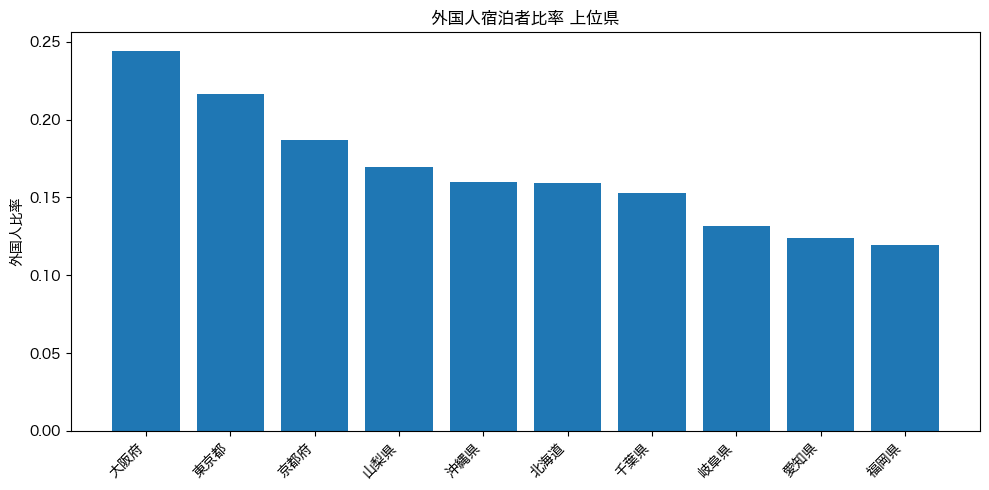

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Hiragino Sans"   # または "Hiragino Maru Gothic Pro"
plt.rcParams["axes.unicode_minus"] = False      # マイナス記号の文字化け防止
import sqlite3
import matplotlib.pyplot as plt

if 'DB_PATH' not in globals():
    DB_PATH = "travel.db"


df['value'] = pd.to_numeric(df['value'], errors='coerce').fillna(0)

print("Columns in df:", df.columns.tolist())

pivot = df.pivot_table(index='施設所在地', columns='宿泊者数', values='value', aggfunc='sum').fillna(0)

required = ['実宿泊者数', 'うち外国人実宿泊者数']
if not all(cat in pivot.columns for cat in required):
    raise KeyError(f"Required categories not found in '宿泊者数'. Found: {pivot.columns.tolist()}")

result = pivot.reset_index().rename(columns={'施設所在地': '都道府県'})

result['うち外国人実宿泊者数'] = pd.to_numeric(result['うち外国人実宿泊者数'], errors='coerce').fillna(0)
result['実宿泊者数'] = pd.to_numeric(result['実宿泊者数'], errors='coerce').fillna(0)

result['外国人宿泊者数'] = result['うち外国人実宿泊者数']
result['日本人宿泊者数'] = result['実宿泊者数'] - result['うち外国人実宿泊者数']

df_use = result[['都道府県', '日本人宿泊者数', '外国人宿泊者数']]

conn = sqlite3.connect(DB_PATH)
df_use.to_sql("lodging_stats", conn, if_exists="replace", index=False)
conn.close()

class LodgingAnalyzer:
    def __init__(self, db_path=DB_PATH):
        self.conn = sqlite3.connect(db_path)

    def get_top_foreign_ratio(self, top_n=10):
        q = """
        SELECT 都道府県,
               日本人宿泊者数 AS jp,
               外国人宿泊者数 AS foreign_count
        FROM lodging_stats
        """
        dfq = pd.read_sql_query(q, self.conn)

        denom = pd.to_numeric(dfq["jp"], errors='coerce').fillna(0) + pd.to_numeric(dfq["foreign_count"], errors='coerce').fillna(0)
        dfq["ratio"] = (pd.to_numeric(dfq["foreign_count"], errors='coerce').fillna(0) / denom).fillna(0).astype(float)
        return dfq.sort_values("ratio", ascending=False).head(top_n)

    def plot_top_foreign_ratio(self, top_n=10):
        dfp = self.get_top_foreign_ratio(top_n)

        x = list(range(len(dfp)))
        heights = pd.to_numeric(dfp["ratio"], errors='coerce').fillna(0).astype(float).to_numpy()

        plt.figure(figsize=(10, 5))
        plt.bar(x, heights)
        plt.xticks(x, dfp["都道府県"], rotation=45, ha='right')
        plt.ylabel("外国人比率")
        plt.title("外国人宿泊者比率 上位県")
        plt.tight_layout()
        plt.show()

# 実行例
analyzer = LodgingAnalyzer()
print(analyzer.get_top_foreign_ratio(10))
analyzer.plot_top_foreign_ratio(10)